# TEST & XAI
This programme is used to test the models with metrics.    
With Explainable AI (XAI) techniques: 
- we will compare/visualize the 5 last attention layers of each model
- we test prediction and analyse token


/////////////////////////////////////////////////////////////////////////////////////////////////

---> Sentence: 'je suis intéressé pour aller de Melun à Auray'

Ici on voit sur quels tokens d'entrées bert-base-fr-cased porte son attention pour chaque token de sortie. Pour produire son embedding.


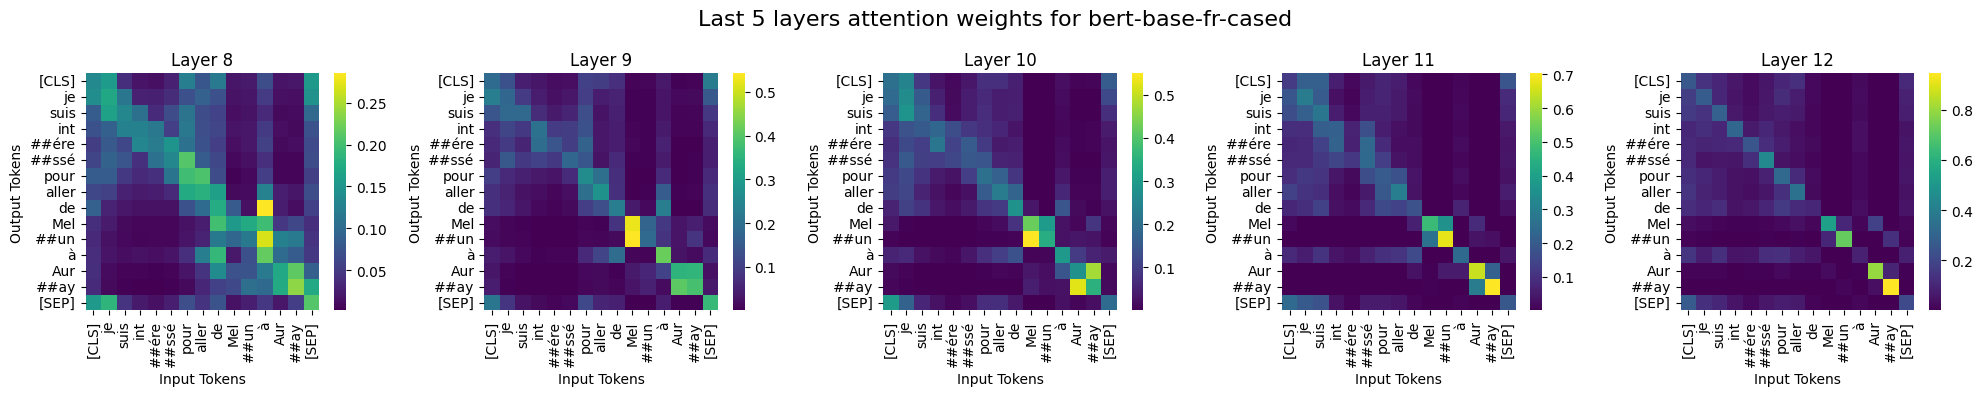

Nombre total de layers: 12
Model: "tf_bert_for_token_classification_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  104262912 
                                                                 
 dropout_793 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 104266757 (397.75 MB)
Trainable params: 104266757 (397.75 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model summary: None

/////////////////////////////////////////////////////////////////////////////////////////////////

---> Sentence: 'je suis intéressé pour aller de Melun à Auray'

Ici on voit sur quels tokens d'entrées

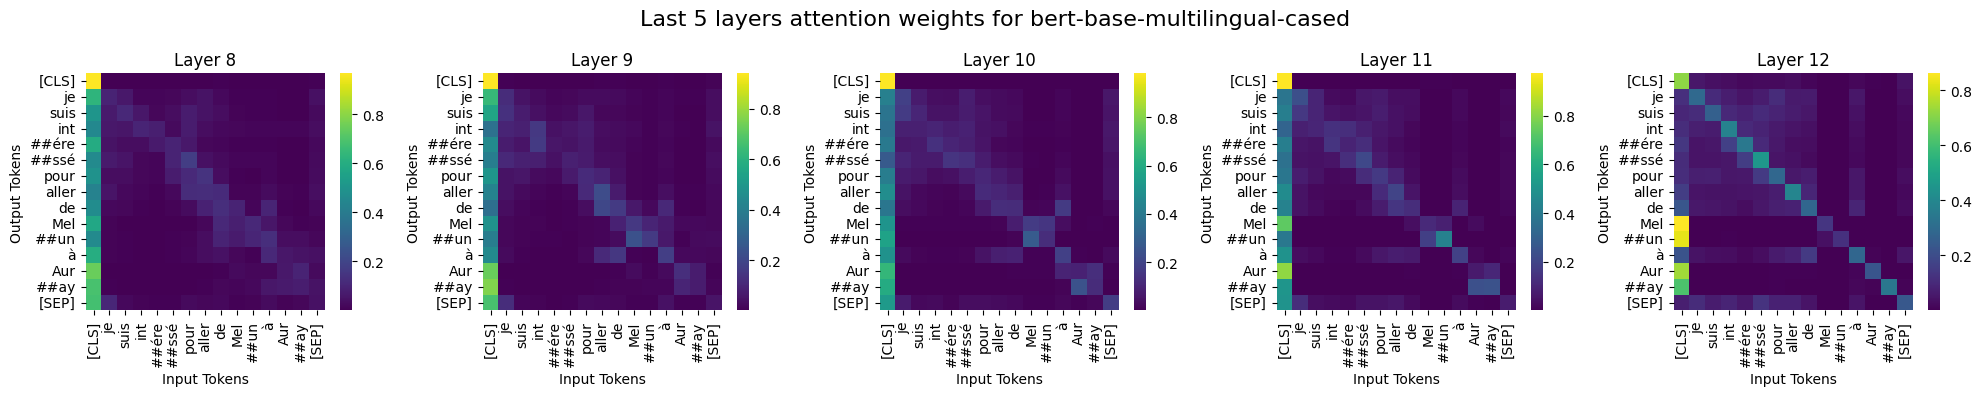

Nombre total de layers: 12
Model: "tf_bert_for_token_classification_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  177262848 
                                                                 
 dropout_831 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 177266693 (676.22 MB)
Trainable params: 177266693 (676.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model summary: None

/////////////////////////////////////////////////////////////////////////////////////////////////

---> Sentence: 'je suis intéressé pour aller de Melun à Auray'

Ici on voit sur quels tokens d'entrées

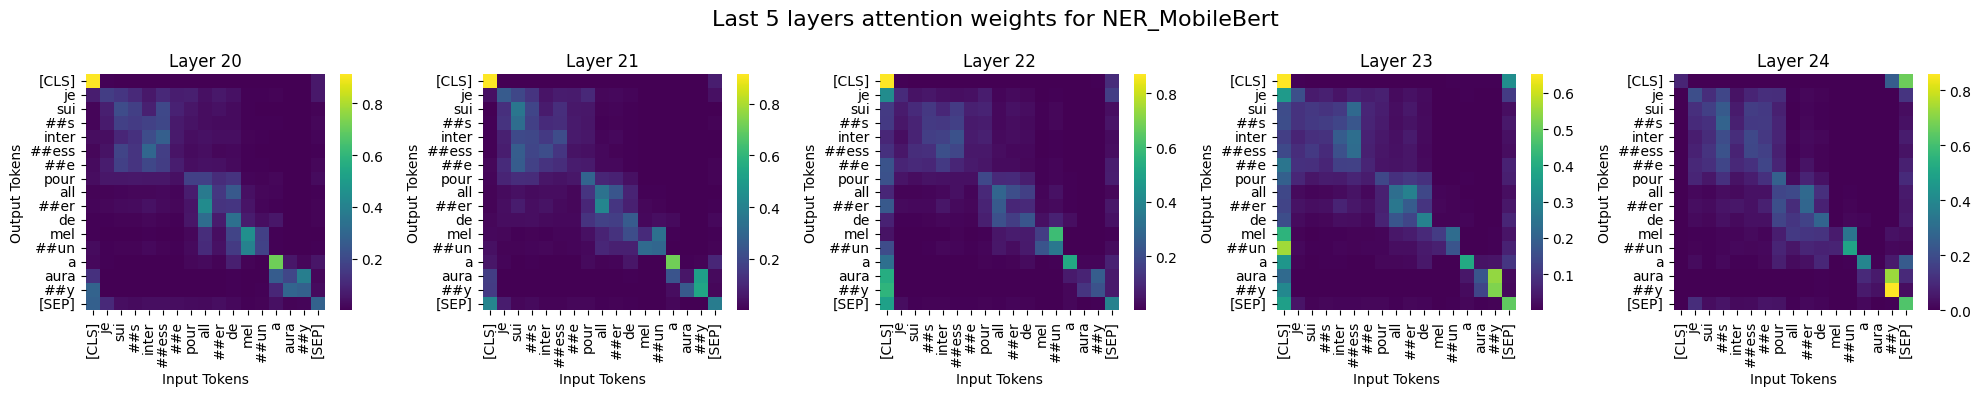

Nombre total de layers: 24
Model: "tf_mobile_bert_for_token_classification_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilebert (TFMobileBertMa  multiple                  24581888  
 inLayer)                                                        
                                                                 
 dropout_881 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2565      
                                                                 
Total params: 24584453 (93.78 MB)
Trainable params: 24584453 (93.78 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model summary: None


In [8]:
import os
import tensorflow as tf
import warnings
from transformers import BertTokenizerFast, TFBertForTokenClassification, TFMobileBertForTokenClassification
from utils import visualize_attention

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore")

phrase_test = "je suis intéressé pour aller de Melun à Auray"

# models
notebook_dir = os.getcwd()
base_dir = os.path.join(notebook_dir, '..', '..', 'model', 'models')
models = {
    model_name: os.path.join(base_dir, model_name) 
    for model_name in os.listdir(base_dir) 
    if os.path.isdir(os.path.join(base_dir, model_name))
}

tokenizers = {}
loaded_models = {}

for name, path in models.items():
    if name in ["NER_MobileBert"]:
        tokenizer = BertTokenizerFast.from_pretrained(path)
        model = TFMobileBertForTokenClassification.from_pretrained(path)
    else:
        tokenizer = BertTokenizerFast.from_pretrained(path)
        model = TFBertForTokenClassification.from_pretrained(path)

    tokenizers[name] = tokenizer
    loaded_models[name] = model


# Last 5 layers of the model
visualize_attention(phrase_test, loaded_models["bert-base-fr-cased"], tokenizers["bert-base-fr-cased"], "bert-base-fr-cased")
visualize_attention(phrase_test, loaded_models["bert-base-multilingual-cased"], tokenizers["bert-base-multilingual-cased"], "bert-base-multilingual-cased")
visualize_attention(phrase_test, loaded_models["NER_MobileBert"], tokenizers["NER_MobileBert"], "NER_MobileBert")



### Évolution de la répartition des poids à travers les couches

Output Tokens - le token que le modèle est en train d'analyser    
Input Tokens - l'ensemble des tokens disponibles en entrée sur lesquels le modèle peut "porter son attention"   

- Les tokens regardent plusieurs autres tokens pour contextualiser leur sens
- Certains tokens se focalisent davantage sur un petit nombre de tokens
- Le modèle affine progressivement la représentation des mots, des liaisons, du sens
- L'embeding est enfin stabilisé avec des mots "autofocusé" pour la tâche de classification

In [9]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from utils import encode_data, print_predict_duration
from transformers import BertTokenizerFast, TFBertForTokenClassification, TFMobileBertForTokenClassification, AutoConfig

from transformers import logging as hf_logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')
hf_logging.set_verbosity_error()

test_phrases = [
    {'Phrase': "je suis intéressé pour aller de Melun à Auray", 'Départ': 'Melun', 'Arrivée': "Auray"},
    {'Phrase': "Depuis Paris, je veux aller à Albert pour boire un Monaco", 'Départ': 'Paris', 'Arrivée': "Albert"}
]
# Access all models
notebook_dir = os.getcwd()
base_dir = os.path.join(notebook_dir, '..', '..', 'model', 'models')
models = {
    model_name: os.path.join(base_dir, model_name)
    for model_name in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, model_name))
}

# Encode data with corresponding labels
unique_labels = ['B-ARR', 'B-DEP', 'I-ARR', 'I-DEP', 'O']
label_encoder = LabelEncoder()
label_encoder.fit(unique_labels)

tokenizers = {}
loaded_models = {}

for model_name, model_path in models.items():
    print(f"Loading model and tokenizer for: {model_name}")
    config = AutoConfig.from_pretrained(model_path, output_attentions=True)
    if model_name in ["NER_MobileBert"]:
        model = TFMobileBertForTokenClassification.from_pretrained(model_path, config=config)
        tokenizer = BertTokenizerFast.from_pretrained(model_path, config=config)
    else:
        model = TFBertForTokenClassification.from_pretrained(model_path, config=config)
        tokenizer = BertTokenizerFast.from_pretrained(model_path)
    
    tokenizers[model_name] = tokenizer
    loaded_models[model_name] = model

# Iterate over all models and test phrases
for model_name in models:
    print("\n/////////////////////////////////////////////")
    print(f"\n---> Processing with model: {model_name}")
    model = loaded_models[model_name]
    tokenizer = tokenizers[model_name]


    for test_phrase in test_phrases:
        start_time = time.time() # start ⏱️...
        encoded_data_with_tokenizer = encode_data(pd.DataFrame([test_phrase]), tokenizer, label_encoder)
        new_tokens, new_labels = encoded_data_with_tokenizer

        new_predictions = model.predict(new_tokens).logits
        new_predicted_labels = np.argmax(new_predictions, axis=-1)

        predicted_label_names = [label_encoder.inverse_transform([label_id])[0] for label_id in new_predicted_labels[0]]
        get_true_labels = [label_encoder.inverse_transform([label_id])[0] for label_id in new_labels[0]]

        prediction_success = predicted_label_names == get_true_labels
        print(f"\n// Prediction success for '{test_phrase['Phrase']}':", prediction_success)

        # Results
        tokens_with_special_tokens = tokenizer.convert_ids_to_tokens(new_tokens[0])

        print("\nResult:")
        print("{:<14} {:<10} {:<8} {:<6}".format("Token", "Predicted", "True", "Result"))
        print("-" * 42)

        for token, predicted_label, true_label in zip(tokens_with_special_tokens, predicted_label_names, get_true_labels):
            result = "✔️" if predicted_label == true_label else "❌"
            print("{:<14} {:<10} {:<8} {:<6}".format(token, predicted_label, true_label, result))

        end_time = time.time() # end ⏱️
        print_predict_duration(start_time, end_time)

Loading model and tokenizer for: bert-base-fr-cased
Loading model and tokenizer for: bert-base-multilingual-cased
Loading model and tokenizer for: NER_MobileBert

/////////////////////////////////////////////

---> Processing with model: bert-base-fr-cased

// Encoding completed
1/1 [==============================] - 4s 4s/step

// Prediction success for 'je suis intéressé pour aller de Melun à Auray': True

Result:
Token          Predicted  True     Result
------------------------------------------
[CLS]          O          O        ✔️    
je             O          O        ✔️    
suis           O          O        ✔️    
int            O          O        ✔️    
##ére          O          O        ✔️    
##ssé          O          O        ✔️    
pour           O          O        ✔️    
aller          O          O        ✔️    
de             O          O        ✔️    
Mel            B-DEP      B-DEP    ✔️    
##un           I-DEP      I-DEP    ✔️    
à              O          O      

### Conclusion
Les modèles bert-base-fr-cased et bert-base-multilingual-cased identifient correctement les entités de destination (DEP et ARR) dans les deux phrases sur des phrases simples.   
En revanche, le modèle NER_MobileBert montre des erreurs sur la deuxième phrase, échouant à détecter correctement "Paris", "Albert" et "Monaco".    
Ces résultats suggèrent que Les BERT sont plus performant que le MobileBERT.